In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../input/train_set.csv')
test = pd.read_csv('../input/test_set.csv')
train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [3]:
cat_features = ['job','marital','education','default','housing','loan','contact','poutcome']
num_features = ['age','balance','day','month','duration','campaign','pdays','previous']
label = train['y']
train.drop('y', axis=1, inplace=True)
test_id = test['ID'].values
data = pd.concat([train, test])
data.drop(['ID'], axis=1, inplace=True)
data.shape

(36169, 16)

In [4]:
#特征工程
#将二分类的特征转换
data['default'] = data['default'].apply(lambda x: 1 if x=='yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x=='yes' else 0)
data['loan'] = data['loan'].apply(lambda x: 1 if x=='yes' else 0)
#对这些特征做一些组合
data['housing_and_loan'] = data['housing'] * data['loan']
data['defualt_and_housing'] = data['default'] * data['housing']
data['defualt_and_loan'] = data['default'] * data['loan']
data['defualt_and_loan_housing'] = data['default'] * data['loan'] * data['housing']
#对年龄做分段处理
def trans_age(x):
    if x<30:
        x=1
    elif x<40:
        x=2
    elif x<60:
        x=3
    else:
        x=4
    return x
data['age_cut'] = data['age'].apply(trans_age)
#对账户余额离散，分段
data['balance<0'] = data['balance'].apply(lambda x: 0 if x<0 else 1)
def balance_cut(x):
    if x<0:
        return 1
    elif x<2000:
        return 2
    else:
        return 3
    return x
data['balance_cut'] = data['balance'].apply(balance_cut)
#对最后一次联系时长做正态变换
data["duration_log"] = np.log1p(data["duration"])
#对活动中客户交流次数离散化
def campaign_cut(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x <= 4:
        return 3
    elif x<=11:
        return 4
    else:
        return 5
data['campaign_cut'] = data['campaign'].apply(campaign_cut)    
#活动交流总次数
data['campaign_add_previous'] = data['campaign'] + data['previous']
data.shape

(36169, 26)

In [5]:
#求groupby后的size特征
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name

for f in['campaign', 'contact','default','education','housing','job','loan','marital','poutcome','pdays','previous']:
    data,_=feature_count(data,['day','month',f])
data.shape

(36169, 37)

In [6]:
# #agg特征
# sparse_feature= ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']
# dense_feature=['age', 'balance','day','duration','campaign','pdays','previous']

# def get_new_columns(name,aggs):
#     l=[]
#     for k in aggs.keys():
#         for agg in aggs[k]:
#             if str(type(agg))=="<class 'function'>":
#                 l.append(name + '_' + k + '_' + 'other')
#             else:
#                 l.append(name + '_' + k + '_' + agg)
#     return l
# for d in sparse_feature:
#     aggs={}
#     for s in sparse_feature:
#         aggs[s]=['count','nunique']
#     for den in dense_feature:
#         aggs[den]=['mean','max','min','std']
#     aggs.pop(d)
#     temp=data.groupby(d).agg(aggs).reset_index()
#     temp.columns=[d]+get_new_columns(d,aggs)
#     data=pd.merge(data,temp,on=d,how='left')
# data.shape

In [7]:
data.drop(['balance','duration','campaign','age'], axis=1, inplace=True)

In [8]:
#离散特征哑编码
one_hot_feature =['job', 'marital','education','default','housing','loan','contact','month','poutcome']
data = pd.get_dummies(data, columns = one_hot_feature)
data.shape

(36169, 68)

In [9]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]
train.shape

(25317, 68)

In [10]:
y = label.values.astype(int)
X = train.values
print("X shape:",X.shape)
print("y shape:",y.shape)


test_data = test.values
print("test shape",test_data.shape)

X shape: (25317, 68)
y shape: (25317,)
test shape (10852, 68)


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import time
start = time.time()
N = 5 
skf = StratifiedKFold(n_splits=N,shuffle=True,random_state=2019)

auc_cv = []
pred_cv = []

for k,(train_in,test_in) in enumerate(skf.split(X,y)):
    X_train, X_test, y_train, y_test = X[train_in], X[test_in], y[train_in], y[test_in]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': 4,
        'min_child_weight': 6,
        'num_leaves': 16,
        'learning_rate': 0.02,# 0.05
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        #'lambda_l1':0.25,
        #'lambda_l2':0.5,
        #'scale_pos_weight':10.0/1.0, #14309.0 / 691.0, #不设置
        #'num_threads':4,
    }
    
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=100,
                    verbose_eval=100)
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    tmp_auc = roc_auc_score(y_test,y_pred)
    auc_cv.append(tmp_auc)
    print("valid auc:",tmp_auc)
    pred = gbm.predict(test_data, num_iteration = gbm.best_iteration)
    pred_cv.append(pred) 

print('the cv information:')
print(auc_cv)
print('cv mean score',np.mean(auc_cv))

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.934501
[200]	valid_0's auc: 0.937531
[300]	valid_0's auc: 0.939517
[400]	valid_0's auc: 0.940736
[500]	valid_0's auc: 0.941704
[600]	valid_0's auc: 0.942206
[700]	valid_0's auc: 0.942321
[800]	valid_0's auc: 0.942364
Early stopping, best iteration is:
[791]	valid_0's auc: 0.942451
valid auc: 0.9424506089228235
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.936036
[200]	valid_0's auc: 0.93957
[300]	valid_0's auc: 0.940866
[400]	valid_0's auc: 0.942007
[500]	valid_0's auc: 0.942521
[600]	valid_0's auc: 0.94308
[700]	valid_0's auc: 0.943505
[800]	valid_0's auc: 0.943741
Early stopping, best iteration is:
[773]	valid_0's auc: 0.943806
valid auc: 0.9438056514353763
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.924791
[200]	valid_0's auc: 0.929135
[300]	valid_0's auc: 0.931689
[400]	valid_0's auc: 0.932978
[500]	valid_0's auc: 0.

有用的特征个数: 65
有用的特征： ['duration_log', 'count_day_month_housing', 'count_day_month_contact', 'day', 'count_day_month_poutcome', 'count_day_month_campaign', 'count_day_month_marital', 'count_day_month_job', 'count_day_month_education', 'pdays', 'count_day_month_loan', 'count_day_month_default', 'count_day_month_pdays', 'campaign_add_previous', 'age_cut', 'count_day_month_previous', 'campaign_cut', 'poutcome_success', 'contact_cellular', 'month_apr', 'contact_unknown', 'housing_0', 'balance_cut', 'education_tertiary', 'month_mar', 'month_jun', 'month_feb', 'previous', 'marital_married', 'job_admin.', 'month_jan', 'month_may', 'job_management', 'housing_1', 'education_primary', 'poutcome_failure', 'marital_single', 'poutcome_other', 'education_secondary', 'job_entrepreneur', 'job_blue-collar', 'month_oct', 'job_housemaid', 'month_jul', 'month_aug', 'loan_0', 'contact_telephone', 'balance<0', 'job_technician', 'job_student', 'month_nov', 'housing_and_loan', 'marital_divorced', 'job_self-emplo

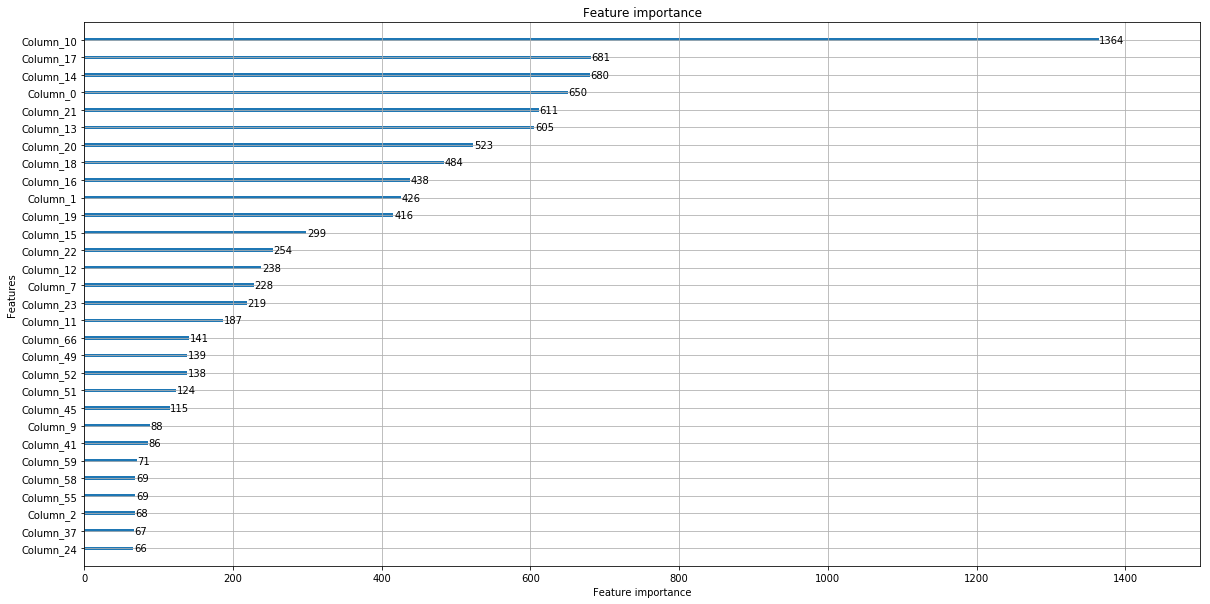

In [12]:
lgb.plot_importance(gbm,max_num_features = 30,figsize=(20,10))
df = pd.DataFrame({'feature': train.columns.tolist(),'importance': gbm.feature_importance()}).sort_values(by='importance',ascending = False) # 降序
use = df.loc[df['importance']!=0,'feature'].tolist()
print('有用的特征个数:',len(use))
print('有用的特征：',use)

In [13]:
# 5折交叉验证结果均值融合，保存文件
mean_auc = np.mean(auc_cv)
print("mean auc:",mean_auc)
filepath = 'lgb_'+ str(mean_auc)+'.csv' # 线下平均分数
# 转为array
res =  np.array(pred_cv)
print("总的结果：",res.shape)
# 最后结果平均，mean
lgb_r = res.mean(axis = 0)
print('result shape:',lgb_r.shape)
lgb_result = pd.DataFrame()
lgb_result['ID'] = test_id
lgb_result['pred'] = lgb_r
lgb_result.to_csv(filepath,index=False,sep=",")

mean auc: 0.9392024450449756
总的结果： (5, 10852)
result shape: (10852,)


In [14]:
# xgb模型，5折交叉训练与验证
import xgboost as xgb
start = time.time()

auc_list = []
pred_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #参数设置
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.02,
              'max_depth':4,
              'min_child_weight': 6,  
              'colsample_bytree': 0.7,
              'subsample': 0.7,
              #'gamma':0,
              #'lambda':1,
              #'alpha ':0，
              'silent':1
              }
    params['eval_metric'] = ['auc'] 
    # 数据结构
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvali = xgb.DMatrix(X_test,label = y_test)
    evallist  = [(dtrain,'train'),(dvali,'valid')]  # 'valid-auc' will be used for early stopping
    # 模型train
    model = xgb.train(params, dtrain,
                      num_boost_round=2000, 
                      evals = evallist,
                      early_stopping_rounds = 100,
                      verbose_eval=100)
    # 预测验证
    pred = model.predict(dvali, ntree_limit = model.best_ntree_limit)
    # 评估
    auc = roc_auc_score(y_test,pred)
    print('...........................auc value:',auc)
    auc_list.append(auc)
    # 预测
    dtest = xgb.DMatrix(test_data)
    pre = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    pred_list.append(pre)

print('......................validate result mean :',np.mean(auc_list))

end = time.time()
print("......................run with time: ",(end - start) / 60.0)

[0]	train-auc:0.754689	valid-auc:0.74799
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.934987	valid-auc:0.924816
[200]	train-auc:0.942822	valid-auc:0.930313
[300]	train-auc:0.947382	valid-auc:0.931864
[400]	train-auc:0.950689	valid-auc:0.933277
[500]	train-auc:0.953946	valid-auc:0.933921
[600]	train-auc:0.956273	valid-auc:0.934452
[700]	train-auc:0.958449	valid-auc:0.934742
Stopping. Best iteration:
[681]	train-auc:0.957991	valid-auc:0.934818

...........................auc value: 0.9348183337506448
[0]	train-auc:0.895728	valid-auc:0.888014
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.934193	valid-auc:0.929157
[200]	train-auc:0.941754	valid-auc:0.935952
[300]	train-auc:0.946164	valid-auc:0.93807
[400]	train-auc:0.949304	valid-auc:0.939435
[500]	train-auc:0.

In [15]:
# 11.5折结果均值融合，并保存文件
mean_auc = np.mean(auc_list)
print("mean auc:",mean_auc)
filepath = 'xgb_'+ str(mean_auc)+'.csv' # 线下平均分数
# 转为array
res =  np.array(pred_list)
print("5折结果：",res.shape)

# 最后结果，mean
xgb_r = res.mean(axis = 0)
print('result shape:',xgb_r.shape)
xgb_result = pd.DataFrame()
xgb_result['ID'] = test_id
xgb_result['pred'] = xgb_r
xgb_result.to_csv(filepath,index=False,sep=",")

mean auc: 0.9396530705354845
5折结果： (5, 10852)
result shape: (10852,)


In [16]:
result = pd.DataFrame()
result['ID'] = test_id
result['pred'] = lgb_r * 0.5 + xgb_r * 0.5
result.to_csv('lgb_xgb_stacking.csv',index=False,sep=",")